In [3]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [4]:
!ls "/content/drive/MyDrive/"

'Colab Notebooks'   MURA-v1.1.zip


In [5]:
!cp "/content/drive/MyDrive/MURA-v1.1.zip" /content/

In [6]:
!ls /content/

drive  MURA-v1.1.zip  sample_data


In [7]:
!unzip -q "/content/MURA-v1.1.zip" -d "/content/MURA"


In [8]:
!ls /content/MURA

MURA-v1.1


In [9]:
import pandas as pd

train_labels = pd.read_csv("/content/MURA/MURA-v1.1/train_labeled_studies.csv")
valid_labels = pd.read_csv("/content/MURA/MURA-v1.1/valid_labeled_studies.csv")

train_labels.head()


,MURA-v1.1/train/XR_SHOULDER/patient00001/study1_positive/,1
0,MURA-v1.1/train/XR_SHOULDER/patient00002/study...,1
1,MURA-v1.1/train/XR_SHOULDER/patient00003/study...,1
2,MURA-v1.1/train/XR_SHOULDER/patient00004/study...,1
3,MURA-v1.1/train/XR_SHOULDER/patient00005/study...,1
4,MURA-v1.1/train/XR_SHOULDER/patient00006/study...,1


In [10]:
!unzip -q /content/MURA-v1.1.zip -d /content/

In [11]:
import pandas as pd

train_labels = pd.read_csv("/content/MURA-v1.1/train_labeled_studies.csv", header=None)
train_labels.head()

,0,1
0,MURA-v1.1/train/XR_SHOULDER/patient00001/study...,1
1,MURA-v1.1/train/XR_SHOULDER/patient00002/study...,1
2,MURA-v1.1/train/XR_SHOULDER/patient00003/study...,1
3,MURA-v1.1/train/XR_SHOULDER/patient00004/study...,1
4,MURA-v1.1/train/XR_SHOULDER/patient00005/study...,1


In [12]:
import glob
import os

all_image_paths = []
all_labels = []

for path, label in zip(train_labels[0], train_labels[1]):
    images = glob.glob(os.path.join("/content", path, "*.png"))
    all_image_paths.extend(images)
    all_labels.extend([label] * len(images))

print("Total images:", len(all_image_paths))
print(all_image_paths[:5])
print(all_labels[:5])


Total images: 36808
['/content/MURA-v1.1/train/XR_SHOULDER/patient00001/study1_positive/image1.png', '/content/MURA-v1.1/train/XR_SHOULDER/patient00001/study1_positive/image3.png', '/content/MURA-v1.1/train/XR_SHOULDER/patient00001/study1_positive/image2.png', '/content/MURA-v1.1/train/XR_SHOULDER/patient00002/study1_positive/image1.png', '/content/MURA-v1.1/train/XR_SHOULDER/patient00002/study1_positive/image3.png']
[1, 1, 1, 1, 1]


In [13]:
import tensorflow as tf

IMG_SIZE = 224
BATCH_SIZE = 32

def process_image(file_path, label):
    img = tf.io.read_file(file_path)
    img = tf.image.decode_png(img, channels=3)
    img = tf.image.resize(img, [IMG_SIZE, IMG_SIZE])
    img = img / 255.0
    return img, label

dataset = tf.data.Dataset.from_tensor_slices((all_image_paths, all_labels))
dataset = dataset.map(process_image)
dataset = dataset.shuffle(1000).batch(BATCH_SIZE)

In [14]:
VAL_SPLIT = 0.2
val_size = int(len(all_image_paths) * VAL_SPLIT)

train_ds = dataset.skip(val_size)
val_ds = dataset.take(val_size)

In [15]:
from tensorflow.keras import layers, models

model = models.Sequential([
    layers.Conv2D(32, (3,3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE,3)),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(128, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),

    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')   # binary classification
])

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    11,075,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,169,089 (42.61 MB)

 Trainable params: 11,169,089 (42.61 MB)

 Non-trainable params: 0 (0.00 B)

In [16]:
from sklearn.model_selection import train_test_split

train_paths, val_paths, train_labels_list, val_labels_list = train_test_split(
    all_image_paths, all_labels, test_size=0.2, random_state=42, stratify=all_labels
)


In [17]:
def create_tf_dataset(paths, labels, batch_size=32, shuffle=True):
    ds = tf.data.Dataset.from_tensor_slices((paths, labels))
    ds = ds.map(process_image)
    if shuffle:
        ds = ds.shuffle(1000)
    ds = ds.batch(batch_size)
    return ds.prefetch(tf.data.AUTOTUNE)

train_ds = create_tf_dataset(train_paths, train_labels_list)
val_ds = create_tf_dataset(val_paths, val_labels_list, shuffle=False)

In [18]:
EPOCHS = 10
history = model.fit(train_ds, validation_data=val_ds, epochs=EPOCHS)

Epoch 1/10
921/921 ━━━━━━━━━━━━━━━━━━━━ 139s 137ms/step - accuracy: 0.5991 - loss: 0.6684 - val_accuracy: 0.6088 - val_loss: 0.6563
Epoch 2/10
921/921 ━━━━━━━━━━━━━━━━━━━━ 112s 118ms/step - accuracy: 0.6139 - loss: 0.6502 - val_accuracy: 0.6333 - val_loss: 0.6383
Epoch 3/10
921/921 ━━━━━━━━━━━━━━━━━━━━ 106s 113ms/step - accuracy: 0.6454 - loss: 0.6259 - val_accuracy: 0.6451 - val_loss: 0.6288
Epoch 4/10
921/921 ━━━━━━━━━━━━━━━━━━━━ 107s 113ms/step - accuracy: 0.6834 - loss: 0.5818 - val_accuracy: 0.6600 - val_loss: 0.6415
Epoch 5/10
921/921 ━━━━━━━━━━━━━━━━━━━━ 139s 110ms/step - accuracy: 0.7364 - loss: 0.5187 - val_accuracy: 0.6611 - val_loss: 0.7045
Epoch 6/10
921/921 ━━━━━━━━━━━━━━━━━━━━ 106s 111ms/step - accuracy: 0.7848 - loss: 0.4426 - val_accuracy: 0.6491 - val_loss: 0.7632
Epoch 7/10
921/921 ━━━━━━━━━━━━━━━━━━━━ 105s 111ms/step - accuracy: 0.8302 - loss: 0.3683 - val_accuracy: 0.6534 - val_loss: 0.8737
Epoch 8/10
921/921 ━━━━━━━━━━━━━━━━━━━━ 106s 113ms/step - accuracy: 0.8663 -

In [19]:
val_loss, val_acc = model.evaluate(val_ds)
print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.4f}")

231/231 ━━━━━━━━━━━━━━━━━━━━ 20s 85ms/step - accuracy: 0.6655 - loss: 1.1466
Validation Loss: 1.1334, Validation Accuracy: 0.6568


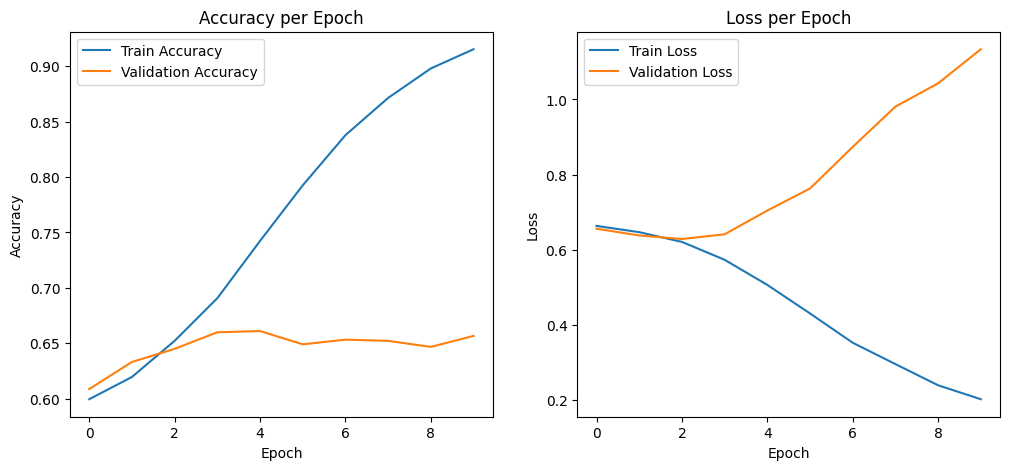

In [20]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))

# Accuracy
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [21]:
import numpy as np
from tensorflow.keras.preprocessing import image

def predict_image(img_path):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_png(img, channels=3)
    img = tf.image.resize(img, [IMG_SIZE, IMG_SIZE])
    img = img / 255.0
    img = np.expand_dims(img, axis=0)
    pred = model.predict(img)[0][0]
    return "Fractured" if pred > 0.5 else "Normal"

test_img_path = val_paths[0]
print(f"Prediction: {predict_image(test_img_path)}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Prediction: Fractured


In [24]:
#Choose data from dataset to test model
img_path = "/content/MURA-v1.1/train/XR_SHOULDER/patient00465/study1_positive/image1.png"
print(predict_image(img_path))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Fractured


In [25]:
#Upload custom test data to test on model
from google.colab import files
uploaded = files.upload()

for filename in uploaded.keys():
    print("Selected:", filename)
    print("Prediction:", predict_image(filename))

Saving fracture.png to fracture.png
Selected: fracture.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Prediction: Normal


In [23]:

model.save("/content/drive/MyDrive/Fracture_Detection_Model.h5")

In [26]:
from tensorflow.keras.models import load_model
model = load_model("/content/drive/MyDrive/Fracture_Detection_Model.h5")


In [28]:
!git config --global user.email "srujan.s719@gmail.com"
!git config --global user.name "srujan-io"


In [29]:
!git clone https://github.com/srujan-io/Fracture_Detection_Nexus.git



Cloning into 'Fracture_Detection_Nexus'...
remote: Enumerating objects: 8, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 8 (delta 0), reused 3 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (8/8), 70.79 KiB | 609.00 KiB/s, done.


In [34]:
!find /content -name "*.h5"




/content/drive/MyDrive/Fracture_Detection_Model.h5


In [35]:
!cp "/content/drive/MyDrive/Fracture_Detection_Model.h5" "/content/Fracture_Detection_Nexus/"


cp: cannot stat '/content/drive/MyDrive/Nexus_Project.ipynb': No such file or directory
